In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import xgboost as xgb
from xgboost import plot_importance

In [2]:
path='./data/'
data = pd.read_csv(path + 'concat78.csv')

In [3]:
scale_cols = ['long_resd', 'long_work', 'long_visit','short_visit_pop_cnt', '배달_cnt', '마트_cnt',
              '내국resd', '내국work', '내국visit', '거주foreign', '거주total', '거주resid']
df_scaled = np.log1p(data[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

#톤 변환
data['em_g']=data['em_g']/1000000
data['em_g']=np.log1p(data['em_g'])

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['emd_nm'])
data['emd_nm'] = encoder.transform(data['emd_nm'])

temp = data.drop(scale_cols, axis=1)
temp = pd.concat([temp,df_scaled],axis=1).reset_index(drop=True)
temp.head(1)

,year,month,emd_nm,season,holiday_cnt,em_g,long_resd,long_work,long_visit,short_visit_pop_cnt,배달_cnt,마트_cnt,내국resd,내국work,내국visit,거주foreign,거주total,거주resid
0,2018,1,0,3,1.0,3.842599,2.260079,0.887339,2.372014,2.946562,3.020425,6.340416,5.224089,3.307855,5.224443,4.744932,8.520189,8.497195


In [4]:
i=temp[(temp['year']==2021)&(temp['month']==7)].index[0]
train = data[:i].reset_index(drop=True)
test = data[i:].reset_index(drop=True)

# XGBoost

In [5]:
cols = train.columns[train.columns!='em_g']
X_train = train[cols]
X_test = test[cols]

y_train = train['em_g']

X_train.shape,X_test.shape, y_train.shape

((1764, 17), (84, 17), (1764,))

[0]	validation_0-rmse:3.23530
[1]	validation_0-rmse:3.07553
[2]	validation_0-rmse:2.92325
[3]	validation_0-rmse:2.77961
[4]	validation_0-rmse:2.64353
[5]	validation_0-rmse:2.51329
[6]	validation_0-rmse:2.39092
[7]	validation_0-rmse:2.27430
[8]	validation_0-rmse:2.16378
[9]	validation_0-rmse:2.05805
[10]	validation_0-rmse:1.95799
[11]	validation_0-rmse:1.86383
[12]	validation_0-rmse:1.77320
[13]	validation_0-rmse:1.68768
[14]	validation_0-rmse:1.60821
[15]	validation_0-rmse:1.53098
[16]	validation_0-rmse:1.45827
[17]	validation_0-rmse:1.38930
[18]	validation_0-rmse:1.32279
[19]	validation_0-rmse:1.26126
[20]	validation_0-rmse:1.20106
[21]	validation_0-rmse:1.14475
[22]	validation_0-rmse:1.09191
[23]	validation_0-rmse:1.04197
[24]	validation_0-rmse:0.99462
[25]	validation_0-rmse:0.94914
[26]	validation_0-rmse:0.90609
[27]	validation_0-rmse:0.86512
[28]	validation_0-rmse:0.82547
[29]	validation_0-rmse:0.78831
[30]	validation_0-rmse:0.75370
[31]	validation_0-rmse:0.72037
[32]	validation_0-

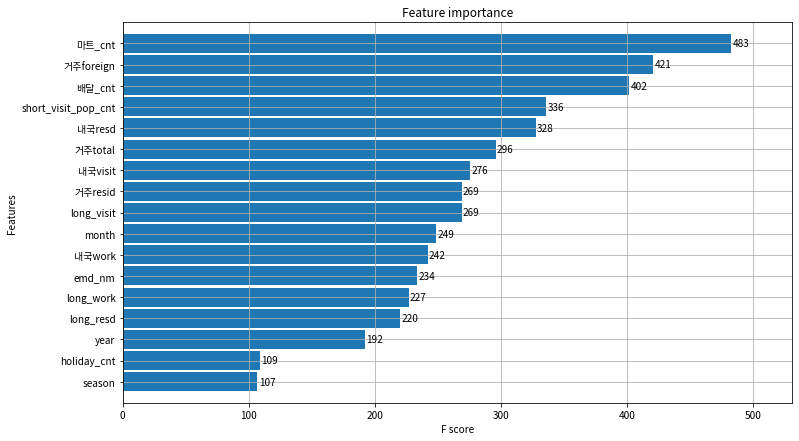

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

XG_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=4,  monotone_constraints='()',
             n_estimators=240, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=41, reg_alpha=0.05,
             reg_lambda=0.2, scale_pos_weight=17.0, subsample=0.7,
             tree_method='auto', validate_parameters=1, verbosity=0)
XG_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds=50,verbose=True)

# 주요하게 적용하는 변수를 판단
plt.rcParams["figure.figsize"] = (12, 7)
plot_importance(XG_model, height=0.9)
xgboost = XG_model.predict(X_test)

# 제출 값 생성

In [7]:
sub = pd.read_excel('/project/2021bigcontest/평가데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_ECO제주_평가데이터_210806_update.xlsx', header=2,index_col='NO')
sub = sub.sort_values('행정동명')
sub['7월 배출량(g)'] = np.expm1(xgboost[:42])*1000000
sub['8월 배출량(g)'] = np.expm1(xgboost[42:])*1000000
sub = sub.sort_values(by='NO')

In [8]:
sub

,행정동명,7월 배출량(g),8월 배출량(g)
NO,,,
1,한림읍,7.578923e+07,7.592872e+07
2,애월읍,9.555955e+07,9.006181e+07
3,구좌읍,2.989358e+07,3.068265e+07
4,조천읍,6.815165e+07,6.851959e+07
5,한경면,1.913213e+07,1.944487e+07
6,일도1동,1.212487e+07,1.166209e+07
7,일도2동,1.467571e+08,1.496582e+08
8,이도1동,3.404465e+07,3.250201e+07
9,이도2동,2.251089e+08,2.201762e+08


In [11]:
sub.to_csv('./data/submission.csv')